In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import gc
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_log_error
import lightgbm as lgb
from matplotlib_venn import venn2
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder

In [3]:
train_df = pd.read_csv('/content/drive/My Drive/youtube_compe/data/train_data.csv')
test_df = pd.read_csv('/content/drive/My Drive/youtube_compe/data/test_data.csv')

### preprocessing

In [4]:
# targetを使用したもの
# category_id
category_mean_ = train_df[["categoryId", "y"]].groupby("categoryId").mean().reset_index().rename({"y":"category_mean"}, axis=1)
category_max_ = train_df[["categoryId", "y"]].groupby("categoryId").max().reset_index().rename({"y":"category_max"}, axis=1)
category_min_ = train_df[["categoryId", "y"]].groupby("categoryId").min().reset_index().rename({"y":"category_min"}, axis=1)
category_std_ = train_df[["categoryId", "y"]].groupby("categoryId").std().reset_index().rename({"y":"category_std"}, axis=1)
category_count_ = train_df[["categoryId", "y"]].groupby("categoryId").count().reset_index().rename({"y":"category_count"}, axis=1)
category_q1_ = train_df[["categoryId", "y"]].groupby("categoryId").quantile(0.1).reset_index().rename({"y":"category_q1"}, axis=1)
category_q25_ = train_df[["categoryId", "y"]].groupby("categoryId").quantile(0.25).reset_index().rename({"y":"category_q25"}, axis=1)
category_q5_ = train_df[["categoryId", "y"]].groupby("categoryId").quantile(0.5).reset_index().rename({"y":"category_q5"}, axis=1)
category_q75_ = train_df[["categoryId", "y"]].groupby("categoryId").quantile(0.75).reset_index().rename({"y":"category_q75"}, axis=1)
category_q9_ = train_df[["categoryId", "y"]].groupby("categoryId").quantile(0.9).reset_index().rename({"y":"category_q9"}, axis=1)
# c

In [5]:
train_y = train_df['y']
del train_df["y"]

In [6]:
df = pd.concat([train_df, test_df])

In [7]:
# merge
df = df.merge(category_mean_, how='left', on=["categoryId"])
df = df.merge(category_max_, how='left', on=["categoryId"])
df = df.merge(category_min_, how='left', on=["categoryId"])
df = df.merge(category_std_, how='left', on=["categoryId"])
#df = df.merge(count_, how='left', on=["categoryId"])
df = df.merge(category_q1_, how='left', on=["categoryId"])
df = df.merge(category_q25_, how='left', on=["categoryId"])
df = df.merge(category_q5_, how='left', on=["categoryId"])
df = df.merge(category_q75_, how='left', on=["categoryId"])
df = df.merge(category_q9_, how='left', on=["categoryId"])

In [8]:
# channelId
le_channelId = LabelEncoder()
df['channelId'] = le_channelId.fit_transform(df['channelId'])

In [9]:
# drop id , video_id  and thumbnail_link
del df['id']
del df['video_id']
del df['thumbnail_link']

In [10]:
# publishedAt
df["publishedAt"] = pd.to_datetime(df["publishedAt"])
df["year"] = df["publishedAt"].dt.year
df["month"] = df["publishedAt"].dt.month
df["day"] = df["publishedAt"].dt.day
df["hour"] = df["publishedAt"].dt.hour
df["minute"] = df["publishedAt"].dt.minute
del df["publishedAt"]

In [11]:
# collection_date
df["collection_date"] = "20" + df["collection_date"]
df["collection_date"] = pd.to_datetime(df["collection_date"], format="%Y.%d.%m")
df["c_year"] = df["collection_date"].dt.year
df["c_month"] = df["collection_date"].dt.month
df["c_day"] = df["collection_date"].dt.day
del df["collection_date"]

In [12]:
# like and dislikes
df['evaluation'] = df['likes'] + df['dislikes']
df['eval_by_comment'] = df['evaluation'] * df['comment_count']
df["logdislikes"] = np.log(df["dislikes"]+1)
df["logcomment_count"] = np.log(df["comment_count"]+1)
df["sqrtlikes"] = np.sqrt(df["likes"])
df["like_dislike_ratio"] = df["likes"]/(df["dislikes"]+1)
df["comments_like_ratio"] = df["comment_count"]/(df["likes"]+1)
df["comments_dislike_ratio"] = df["comment_count"]/(df["dislikes"]+1)
# likes comments diable
df["likes_com"] = df["likes"] * df["comments_disabled"]
df["dislikes_com"] = df["dislikes"] * df["comments_disabled"]
df["comments_likes"] = df["comment_count"] * df["ratings_disabled"]

In [13]:
#channel TItle
channel_title_doct = df['channelTitle'].value_counts().to_dict()
df['channelTItle_count'] = df['channelTitle'].apply(lambda x: channel_title_doct[x] if x in channel_title_doct else 0)

In [14]:
# length_tags
df["num_tags"] = df["tags"].astype(str).apply(lambda x: len(x.split("|")))
df["length_tags"] = df["tags"].astype(str).apply(lambda x: len(x))

In [15]:
# title
df['official']  = df['title'].apply(lambda x: True if 'Official' in x else False)
df['title_length'] = df['title'].apply(lambda x: len(x))

In [16]:
# description

In [17]:
df.head(4)

,title,channelId,channelTitle,categoryId,tags,likes,dislikes,comment_count,comments_disabled,ratings_disabled,description,mean,max,min,std,q1,q25,q5,q75,q9,year,month,day,hour,minute,c_year,c_month,c_day,evaluation,eval_by_comment,logdislikes,logcomment_count,sqrtlikes,like_dislike_ratio,comments_like_ratio,comments_dislike_ratio,likes_com,dislikes_com,comments_likes,channelTItle_count,num_tags,length_tags,official,title_length
0,[12] BGM Inazuma Eleven 3 - ~ライオコツト ダンジョン~,7498,DjangoShiny,20,Inazuma|Eleven|Super|Once|bgm|ost|イナズマイレブン|Kyo...,114,0,7,False,False,~ライオコツト ダンジョン~Inazuma Eleven 3 BGM Complete (R...,1.110494e+06,1.953992e+07,48.0,2.052324e+06,30670.4,121542.25,433934.5,1162340.25,2603043.6,2011,1,9,5,50,2020,2,1,114,798,0.000000,2.079442,10.677078,114.000000,0.060870,7.000000,0,0,0,1,48,315,False,42
1,ねごと - メルシールー [Official Music Video],12289,ねごと Official Channel,10,ねごと|ネゴト|メルシールー|Re:myend|リマインド|Lightdentity|ライデ...,2885,50,111,False,False,http://www.negoto.com/全員平成生まれ、蒼山幸子（Vo＆Key)、沙田瑞...,7.109256e+06,1.302070e+09,6.0,4.440962e+07,29644.2,119623.50,560720.0,2306314.75,8221974.9,2012,7,23,3,0,2020,2,8,2935,325785,3.931826,4.718499,53.712196,56.568627,0.038462,2.176471,0,0,0,5,19,129,True,35
2,VF3tb 闇よだれvsちび太 (SEGA),3392,siropai,24,VF3|VF4|VF5|ちび太|闇よだれ|chibita|virtuafighter|seg...,133,17,14,False,False,Beat-tribe cup finalhttp://ameblo.jp/siropai/,2.154325e+06,2.271761e+08,3.0,7.964865e+06,17748.0,78524.00,358451.0,1416473.00,4313006.0,2007,7,26,13,54,2020,1,14,150,2100,2.890372,2.708050,11.532563,7.388889,0.104478,0.777778,0,0,0,1,9,52,False,22
3,free frosty weekend!,2243,Jones4Carrie,22,frosty,287,51,173,False,False,I look so bad but look at me!,1.352693e+06,4.178697e+07,8.0,3.811351e+06,3979.8,38162.00,198158.0,942131.50,3289791.0,2005,5,15,2,38,2019,12,22,338,58474,3.951244,5.159055,16.941074,5.519231,0.600694,3.326923,0,0,0,10,1,6,False,20


In [18]:
# 言語処理はあとで行う
df = df.drop(["title","channelTitle","tags","description"], axis=1)

In [19]:
df.head(2)

,channelId,categoryId,likes,dislikes,comment_count,comments_disabled,ratings_disabled,mean,max,min,std,q1,q25,q5,q75,q9,year,month,day,hour,minute,c_year,c_month,c_day,evaluation,eval_by_comment,logdislikes,logcomment_count,sqrtlikes,like_dislike_ratio,comments_like_ratio,comments_dislike_ratio,likes_com,dislikes_com,comments_likes,channelTItle_count,num_tags,length_tags,official,title_length
0,7498,20,114,0,7,False,False,1.110494e+06,1.953992e+07,48.0,2.052324e+06,30670.4,121542.25,433934.5,1162340.25,2603043.6,2011,1,9,5,50,2020,2,1,114,798,0.000000,2.079442,10.677078,114.000000,0.060870,7.000000,0,0,0,1,48,315,False,42
1,12289,10,2885,50,111,False,False,7.109256e+06,1.302070e+09,6.0,4.440962e+07,29644.2,119623.50,560720.0,2306314.75,8221974.9,2012,7,23,3,0,2020,2,8,2935,325785,3.931826,4.718499,53.712196,56.568627,0.038462,2.176471,0,0,0,5,19,129,True,35


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49302 entries, 0 to 49301
Data columns (total 40 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   channelId               49302 non-null  int64  
 1   categoryId              49302 non-null  int64  
 2   likes                   49302 non-null  int64  
 3   dislikes                49302 non-null  int64  
 4   comment_count           49302 non-null  int64  
 5   comments_disabled       49302 non-null  bool   
 6   ratings_disabled        49302 non-null  bool   
 7   mean                    49293 non-null  float64
 8   max                     49293 non-null  float64
 9   min                     49293 non-null  float64
 10  std                     49293 non-null  float64
 11  q1                      49293 non-null  float64
 12  q25                     49293 non-null  float64
 13  q5                      49293 non-null  float64
 14  q75                     49293 non-null

In [21]:
# データの分割
train = df.iloc[:len(train_y), :]
test = df.iloc[len(train_y):, :]

In [42]:
# kfold
cv = KFold(n_splits=5, shuffle=True, random_state=2020)
params = {
    'boosting_type': 'gbdt',
    'metric': 'rmse',
    'objective': 'regression',
    'seed': 20,
    'learning_rate': 0.01,
    "n_jobs": -1,
    "verbose": -1,
    # "max_depth":4,
    # "max_bin": 128,
    # "bagging_fraction":0.5,
    # "lambda_l1":0.1,
    # "lambda_l2":0.04
    # "subsample":0.7, 
    # "colsample_bytree":0.7
}
# params = {'task': 'train',
#         'boosting_type': 'gbdt',
#         'objective': 'regression',
#         'metric': 'rmse',
#         'verbosity': -1,
#         "seed":42,
#         'learning_rate': 0.01,}
# best_params =  {'lambda_l1': 0.019918875912078603,
#                 'lambda_l2': 0.002616688073257713,
#                 'num_leaves': 219, 
#                 'feature_fraction': 0.6641013611124621,
#                 'bagging_fraction': 0.7024199018549259,
#                 'bagging_freq': 5, 
#                 'min_child_samples': 5}

# params.update(best_params)

In [43]:
y = np.log(train_y)
pred =0
score = 0
c =0 

###  training(lgb)

In [44]:
for tr_idx, val_idx in cv.split(train):
    x_train, x_val = train.iloc[tr_idx], train.iloc[val_idx]
    y_train, y_val = y[tr_idx], y[val_idx]
    
    # Datasetに入れて学習させる
    train_set = lgb.Dataset(x_train, y_train)
    val_set = lgb.Dataset(x_val, y_val, reference=train_set)
        
    # Training
    model = lgb.train(params, train_set, num_boost_round=30000, early_stopping_rounds=1000, 
                      valid_sets=[train_set, val_set], verbose_eval=500)
    
    # 予測したらexpで元に戻す
    test_pred = np.exp(model.predict(test))
    # 0より小さな値があるとエラーになるので補正
    test_pred = np.where(test_pred < 0, 0, test_pred)
    pred += test_pred / 5  #  5fold回すので

    oof = np.exp(model.predict(x_val))
    oof = np.where(oof < 0, 0, oof)
    rmsle = np.sqrt(mean_squared_log_error(np.exp(y_val), oof))
    c += 1
    print("{}回目の思考".format(c))
    print(f"RMSLE : {rmsle}")
    score += rmsle/ 5

Training until validation scores don't improve for 1000 rounds.
[500]	training's rmse: 0.744502	valid_1's rmse: 0.836258
[1000]	training's rmse: 0.667512	valid_1's rmse: 0.81935
[1500]	training's rmse: 0.61749	valid_1's rmse: 0.810574
[2000]	training's rmse: 0.57762	valid_1's rmse: 0.807254
[2500]	training's rmse: 0.540293	valid_1's rmse: 0.806878
[3000]	training's rmse: 0.508305	valid_1's rmse: 0.806252
[3500]	training's rmse: 0.479708	valid_1's rmse: 0.806323
[4000]	training's rmse: 0.454584	valid_1's rmse: 0.806126
[4500]	training's rmse: 0.433244	valid_1's rmse: 0.805478
[5000]	training's rmse: 0.4106	valid_1's rmse: 0.804275
[5500]	training's rmse: 0.390484	valid_1's rmse: 0.804856
[6000]	training's rmse: 0.372626	valid_1's rmse: 0.804766
Early stopping, best iteration is:
[5015]	training's rmse: 0.410048	valid_1's rmse: 0.804192
1回目の思考
RMSLE : 0.8033626565885102
Training until validation scores don't improve for 1000 rounds.
[500]	training's rmse: 0.743369	valid_1's rmse: 0.84720

###  training(xgb)

In [ ]:
# xgb_pram = {
    
# }

In [ ]:
# gscv = xgb.XGBRegressor(n_estimators=50000, learning_rate=0.01, max_depth=6, subsample=0.7, colsample_bytree=0.7)
# for tr_idx, val_idx in cv.split(train):
#     x_train, x_val = train.iloc[tr_idx], train.iloc[val_idx]
#     y_train, y_val = y[tr_idx], y[val_idx]
    
#     gscv.fit(x_train, y_train)
#     # 予測したらexpで元に戻す
#     test_pred = np.exp(gscv.predict(test))
#     # 0より小さな値があるとエラーになるので補正
#     test_pred = np.where(test_pred < 0, 0, test_pred)
#     pred += test_pred / 5  #  5fold回すので

#     oof = np.exp(gscv.predict(x_val))
#     oof = np.where(oof < 0, 0, oof)
#     rmsle = np.sqrt(mean_squared_log_error(np.exp(y_val), oof))
#     print(f"RMSLE : {rmsle}")
#     score += rmsle/ 5


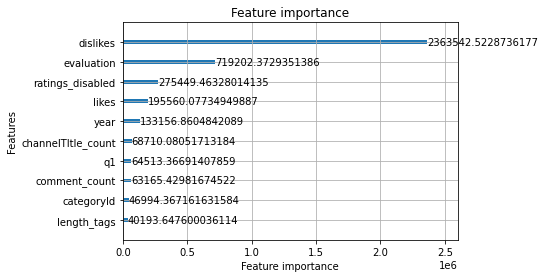

In [45]:
lgb.plot_importance(model, importance_type="gain", max_num_features=10)

In [46]:
print(f"Mean RMSLE SCORE :{score}")

Mean RMSLE SCORE :0.8013948814114352


In [33]:
submit_df = pd.DataFrame({"y": pred})
submit_df.index.name = "id"
submit_df.to_csv("submit.csv")

In [34]:
from google.colab import files
files.download('submit.csv')